# F3

Rasters of spiking activity for MOs units

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from fcutils.progress import track

import sys
sys.path.append("./")
sys.path.append(r"C:\Users\Federico\Documents\GitHub\pysical_locomotion")

from analysis.ephys.utils import get_recording_names, get_data, get_session_bouts
from analysis.ephys.viz import time_aligned_raster, bouts_raster
from myterial import grey_dark


TARGET = "MOs"
get_recording_names(region=TARGET)



array(['FC_220408_BAA1101192_hairpin', 'FC_220409_BAA1101192_hairpin',
       'FC_220410_BAA1101192_hairpin', 'FC_220411_BAA1101192_hairpin',
       'FC_220412_BAA1101192_hairpin', 'FC_220413_BAA1101192_hairpin',
       'FC_220414_BAA1101192_hairpin', 'FC_220415_BAA1101192_hairpin',
       'FC_220432_BAA1101192_hairpin', 'FC_220433_BAA1101192_hairpin',
       'FC_220434_BAA1101192_hairpin', 'FC_220435_BAA1101192_hairpin'],
      dtype=object)

In [38]:
rec = "FC_220433_BAA1101192_hairpin"

units, left_fl, right_fl, left_hl, right_hl, body = get_data(rec)

bouts = get_session_bouts(rec, complete=True)
bouts = bouts.loc[bouts.complete == "true"]
bouts = bouts.loc[bouts.duration < 8]
bouts["s0"] = [b.s[0] for i, b in bouts.iterrows()]
bouts = bouts.loc[bouts.s0 < 50]
bouts = bouts.sort_values("duration", ascending=False)

if TARGET == "MOs":
    units = units.loc[units.brain_region.isin(["MOs", "MOs1", "MOs2/3", "MOs5", "MOs6a", "MOs6b"])]
else:
    units = units.loc[units.brain_region.isin(["CUN", "PPN"])]
    

[07/19/22 11:45:56] INFO     Got 47 units for FC_220433_BAA1101192_hairpin       ]8;id=528870;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=932086;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#189\189]8;;\

[07/19/22 11:45:57] INFO     Got 47 bouts for FC_220433_BAA1101192_hairpin |     ]8;id=326387;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py\utils.py]8;;\:]8;id=702641;file://C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\utils.py#244\244]8;;\
                             True | outbound                                                 

plot bouts rasters for a single unit

<Figure size 720x360 with 1 Axes>

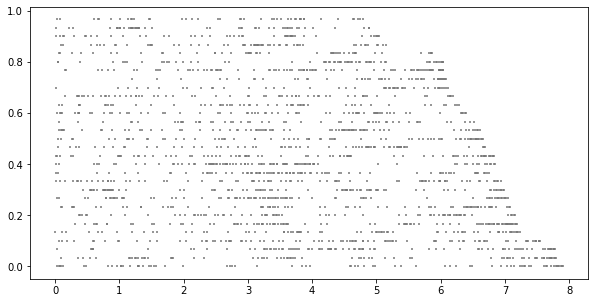

In [46]:
unit = units.iloc[6]


f, ax = plt.subplots(1, 1, figsize=(10, 5))

bouts_start_times = bouts.start_frame.values / 60
bouts_end_times = bouts.end_frame.values / 60
spikes = unit.spikes_ms / 1000

n = len(bouts_start_times)
h = 1 / n

for i, (s, e) in enumerate(zip(bouts_start_times, bouts_end_times)):
    trial_spikes = spikes[(spikes > s) & (spikes < e)] - s
    y = np.zeros_like(trial_spikes) + (i * h)
    ax.scatter(trial_spikes, y, s=6, color=grey_dark, alpha=1, marker="|")


<Figure size 720x360 with 2 Axes>

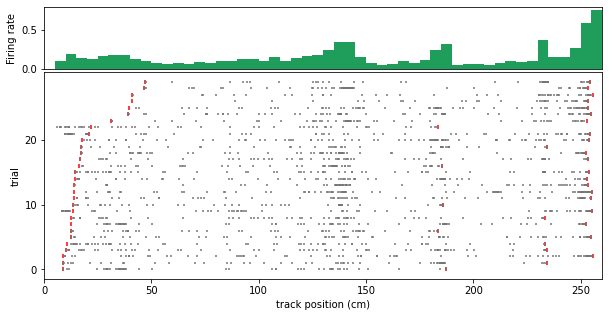

In [96]:
from analysis.ephys.viz import bouts_raster

bouts = bouts.sort_values("s0").reset_index(drop=True)

unit_id = 6
unit = units.iloc[unit_id]

f, ax = plt.subplots(1, 1, figsize=(10, 5))
bouts_raster(ax, unit, bouts, body)

f.savefig(f"D:\\Dropbox (UCL)\\Rotation_vte\\Writings\\THESIS\\Chpt4\\Plots\\example_session_raster_example_unit_{unit_id}.svg", dpi=300)

## Plot whole session rasters for all units

<Figure size 1152x1440 with 3 Axes>

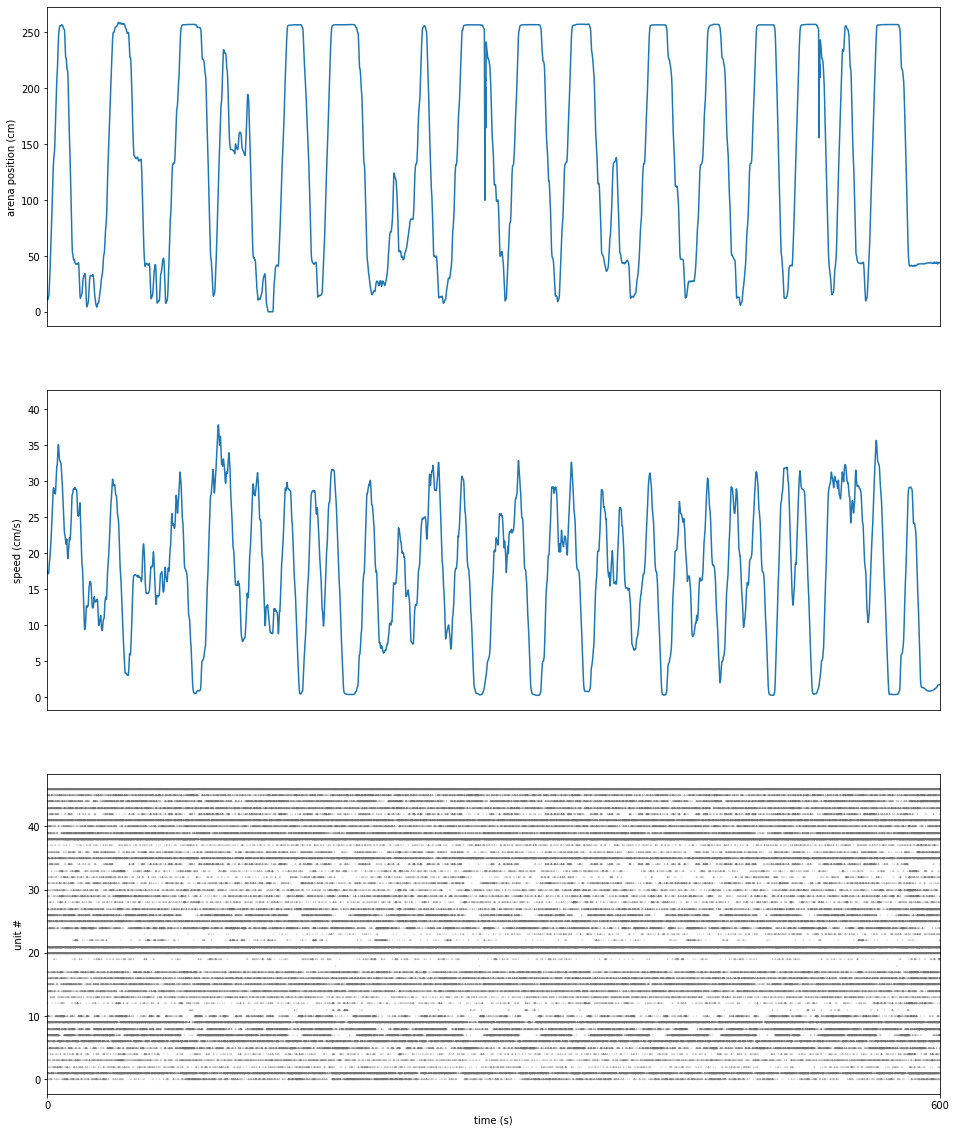

In [92]:
from fcutils.maths.signals import rolling_mean

f, axes = plt.subplots(3, 1, figsize=(16, 20))

axes[0].plot(rolling_mean(body.global_coord * 260, 21))
axes[1].plot(rolling_mean(body.speed, 500))

t0 = 300
duration = 600

for i, unit in units.iterrows():
    # axes[2].plot(rolling_mean(unit.spikes_ms / 1000, 21), alpha=0.1)
    # axes[2].scatter(unit.spikes, np.ones_like(unit.spikes) * i, s=6, color=grey_dark, alpha=1, marker="|")
    axes[2].scatter(unit.spikes, np.ones_like(unit.spikes) * i, s=1, color=grey_dark, alpha=0.2, marker=7)

for ax in axes:
    ax.set(xlim=[t0 * 60, (t0 + duration) * 60],
        xticks = [t0 * 60, (t0 + duration) * 60],
        xticklabels = [0, duration]
    )

axes[0].set(ylabel="arena position (cm)", xticks=[])
axes[1].set(ylabel="speed (cm/s)", xticks=[])
axes[2].set(ylabel="unit #", xlabel="time (s)")

# save figure
f.savefig(f"D:\\Dropbox (UCL)\\Rotation_vte\\Writings\\THESIS\\Chpt4\\Plots\\example_session_raster.svg", dpi=300)

### plot waveforms

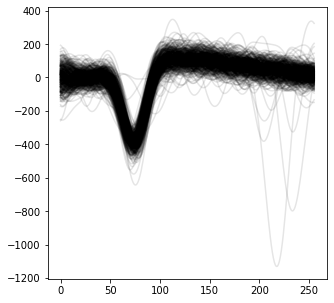

In [92]:
path = "D:\\Dropbox (UCL)\\Rotation_vte\\Writings\\THESIS\\Chpt4\\traces\\first.m"

import scipy.io
import matplotlib.pyplot as plt
import numpy as np
waveform = scipy.io.loadmat(path)
key = list(waveform.keys())[-1]
waveform = waveform[key]
waveform.shape


from fcutils.maths.signals import rolling_mean
from scipy.signal import resample


f, ax = plt.subplots(1, 1, figsize=(5, 5))
for i in np.random.randint(0, waveform.shape[-1], 500):
    channel = np.argmin(np.min(waveform[:, :, i], axis=0))
    spike = waveform[:, channel, i]
    spike = resample(spike, 256)
    spike = rolling_mean(spike, 21)

    _ = ax.plot(spike, color="k", alpha=.1)

# save figure
f.savefig(f"D:\\Dropbox (UCL)\\Rotation_vte\\Writings\\THESIS\\Chpt4\\Plots\\example_waveform_1.svg", dpi=300)
f.savefig(f"D:\\Dropbox (UCL)\\Rotation_vte\\Writings\\THESIS\\Chpt4\\Plots\\example_waveform_1.png", dpi=300)